#### 设置全局参数

In [1]:
import torch
device = torch.device("cuda:1") 
dataset_type = "SteeringAngle"
model_name = "null"
save_origin_pic = False # 是否保留原始图片
save_generate_pic = False # 是否保留生成图片
fid_judge = False # 是否进行fid评估

### 加载相应的库

In [2]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import my_tools
import fid_score as official_fid

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as all_model

if dataset_type == "CIFAR10":
    if model_name == "ResNet20":
        from CIFAR10.models import ResNet20 as classify_model
        from CIFAR10.models import Rob_predictor as my_Rob_predictor
        from CIFAR10.models import BigGAN


import pickle
import os
import numpy as np
from tqdm import tqdm
from PIL import Image  
from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
import pandas as pd
import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import h5py

number = 200000

### 保留原始图片

In [3]:
if save_origin_pic == True and dataset_type == "CIFAR10":
    # number = 50000
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataloader = DataLoader(datasets.CIFAR10('./static/data/CIFAR10/CIFAR10', train=True, download=True, transform=transform), batch_size=1, shuffle=False)
    save_path = './static/data/CIFAR10/pic/origin_50k/'

    index = 0
    for data in train_dataloader:
        img, labels = data
        utils.save_image(img, save_path + 'pic_' + str(index) + '.jpg', nrow=10)
        index += 1
        if index >= number:
            break
elif save_origin_pic == True and dataset_type == "SteeringAngle":
    # data loader
    data_filename = './static/data/SteeringAngle/SteeringAngle/SteeringAngle_64x64.h5'
    hf = h5py.File(data_filename, 'r')
    labels = hf['labels'][:]
    # labels = labels.astype(np.float)
    labels = labels.astype(np.float32) # kjl改
    images = hf['images'][:]
    hf.close()
    N_all = len(images)
    assert len(images) == len(labels)

    # 这段代码的作用是选择标签（labels）在指定范围内的图像（images）和标签（labels），并确保它们数量相等。
    q1 = -80.0
    q2 = 80.0
    indx = np.where((labels>q1)*(labels<q2)==True)[0]
    labels = labels[indx]
    images = images[indx]
    assert len(labels)==len(images)
    print(images.shape)

    save_pic_path = "./static/data/SteeringAngle/pic/origin"

    images = (images/255.0)
    for index, img in enumerate(images):
        utils.save_image(torch.tensor(img), save_pic_path + '/pic_' + str(index) + '.jpg')

### 保留生成图片与z

In [4]:
if save_generate_pic == True and dataset_type == "CIFAR10":
    # 选择生成模型
    checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth"
    G = BigGAN.Generator().to(device)
    G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
    G.eval()
    # number = 200000

    save_pic_path = "./static/data/CIFAR10/pic/random_"+ str(number//1000) +"k"
    
    for num in tqdm(range(number)):
        z = torch.tensor(np.random.RandomState(num).randn(1, 80)).to(torch.float32).to(device)    # latent code
        label = torch.tensor(random.randrange(10)).unsqueeze(0).to(device)
        shared_label = G.shared(label)
        z_and_shared_label = torch.cat((z, shared_label), dim = 1)
        if num == 0:
            z_and_shared_labels = z_and_shared_label
        else:
            z_and_shared_labels = torch.cat((z_and_shared_labels, z_and_shared_label))
        img = G(z = z_and_shared_label)                           # NCHW, float32, dynamic range [-1, +1]
        img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
        # print(z.shape) # [1, 80]
        # print(shared_label.shape) # [1, 128]
        # print(z_and_shared_label.shape) # [1, 208]
        utils.save_image(img.detach().cpu(), save_pic_path + '/pic_' + str(num) + '.jpg')

    torch.save(z_and_shared_labels, './static/data/CIFAR10/latent_z/BigGAN_208z_' + str(number) + '.pt')

elif save_generate_pic == True and dataset_type == "SteeringAngle":
    print("处理SteeringAngle。。。")
    checkpoints_path = "./model_files/SteeringAngle/checkpoints/CcGAN/ckpt_CcGAN_niters_40000_seed_2020_soft.pth"
    G = all_model.get_generative_model("SteeringAngle")
    G = nn.DataParallel(G, device_ids=[1])
    G.load_state_dict(torch.load(checkpoints_path, map_location=device)["netG_state_dict"])
    G = G.to(device)
    G.eval()

    net_y2h = all_model.get_mapping("SteeringAngle").to(device)
    net_y2h_checkpoint = torch.load("./model_files/SteeringAngle/checkpoints/CcGAN/ckpt_net_y2h_epoch_500_seed_2020.pth", map_location=device)
    net_y2h.load_state_dict(net_y2h_checkpoint['net_state_dict'])
    net_y2h.eval()

    # number = 50000

    save_pic_path = "./static/data/SteeringAngle/pic/random_"+ str(number//1000) +"k"
    
    for num in tqdm(range(number)):
        z = torch.tensor(np.random.RandomState(num).randn(1, 256)).to(torch.float32).to(device)    # latent code
        random.seed(num)
        angle = torch.tensor(random.random()).unsqueeze(0).to(device) 
        y_embed = net_y2h(angle)

        img = G(z, y_embed) # NCHW, float32, dynamic range [-1, +1]
        img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内

        utils.save_image(img.detach().cpu(), save_pic_path + '/pic_' + str(num) + '.jpg')

        z_and_embed_y = torch.cat((z, y_embed), dim = 1)
        if num == 0:
            z_and_embed_ys = z_and_embed_y
            angles = angle
        else:
            z_and_embed_ys = torch.cat((z_and_embed_ys, z_and_embed_y))
            angles = torch.cat((angles, angle))

    torch.save(z_and_embed_ys, './static/data/SteeringAngle/latent_z/CcGAN_384z_' + str(number) + '.pt')
    torch.save(angles, './static/data/SteeringAngle/angle/angles_' + str(number) + '.pt')

### 评估fid值

In [5]:
if fid_judge == True:
    # fid计算模型
    dims = 2048
    batch_size = 1
    num_avail_cpus = len(os.sched_getaffinity(0))
    num_workers = min(num_avail_cpus, 8)
    block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    fid_model = official_fid.InceptionV3([block_idx]).to(device)
    print('fid_model load success!')

    if dataset_type == "CIFAR10":
        pic_path_fid1 = './static/data/CIFAR10/pic/random_' + str(number//1000) + 'k'
        pic_path_fid2 = './static/data/CIFAR10/pic/origin_50k'
    
    if dataset_type == "SteeringAngle":
        pic_path_fid1 = './static/data/SteeringAngle/pic/random_200k'
        pic_path_fid2 = './static/data/SteeringAngle/pic/origin'
        
    batch_size = 100
    m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                        dims, device, num_workers)
    fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
    print(fid_value)

### 开始预处理数据

#### 定义自己的数据类

In [6]:
class Mydata_sets(Dataset):
    
    def __init__(self, path, transform=None):
        super(Mydata_sets, self).__init__()
        self.root_dir = path
        self.img_names = os.listdir(self.root_dir)
        self.transform = transform

    def __getitem__(self, index): # 返回transform后的图像和文件的id序号
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.root_dir, img_name))
        id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, id_name

    def __len__(self):
        return len(self.img_names)

if dataset_type == "SteeringAngle":
    # 获取模型
    model = all_model.get_DNN_model("SteeringAngle", "ResNet34_regre").to(device)
    model.load_state_dict(torch.load("./model_files/SteeringAngle/checkpoints/regre_model/ResNet34_regre.pt", map_location=device)["net_state_dict"])
    model.eval()
    # 图片路径
    pic_path = "./static/data/SteeringAngle/pic/random_" + str(number//1000) + "k"   
    transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
            ]
        )
    # 定义一个字典来存储中间层的输出
    activation = {}
    # 针对回归模型，需要hook函数获取倒数第二层的输出
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    # 注册钩子函数到第二层
    model.pool1.register_forward_hook(get_activation('pool1'))

#### 获得图片的特征、类别、文件编号

In [7]:
features, labels, ids = [], [], [] # features：提取的2048维图片特征，labels：模型预测的标签，ids图片文件编号

img_datasets = Mydata_sets(pic_path, transform=transform)  
# img_datasets = torchvision.datasets.CIFAR10("./static/data/CIFAR10/", train=True, download=False, transform=transform) #使用原始的cifar10图片
imgLoader = torch.utils.data.DataLoader(img_datasets, batch_size=128, shuffle=False, num_workers=4)  # 指定读取配置信息

with torch.no_grad():
    for x, y in tqdm(imgLoader):
        x = x.to(device)
        ids.append(y)  # N

        label = model(x)
        labels.append(label)

        feature = activation['pool1']
        feature = feature.view(feature.size(0), -1)
        features.append(feature)


features = torch.cat(features, dim=0).squeeze().cpu().numpy()  # (n, 2048)
labels = torch.cat(labels, dim=0).squeeze().cpu().numpy()  # n
ids = torch.cat(ids, dim=0).cpu().numpy() # n

print(features.shape)
print(labels.shape)
print(ids.shape)

100%|██████████| 1563/1563 [01:49<00:00, 14.23it/s]


(200000, 512)
(200000,)
(200000,)


#### 降维

In [8]:
# 可能比较耗时
embed = TSNE(n_jobs=4).fit(features)  # N, 2

#### 画类别散点图

(200000, 2)
           x          y
0 -25.814376  14.308167
1 -26.108042  40.100266
2  32.996366  30.497766
3 -24.125046 -49.270573
4 -47.103599  82.853595
           x          y     label
0 -25.814376  14.308167  0.101948
1 -26.108042  40.100266  0.649574
2  32.996366  30.497766  0.584181
3 -24.125046 -49.270573  0.532444
4 -47.103599  82.853595  0.839853


<AxesSubplot:xlabel='x', ylabel='y'>

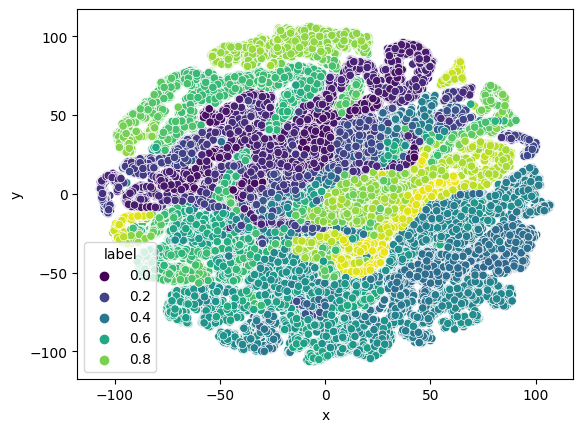

In [16]:
pd_embed = pd.DataFrame(embed)
print(pd_embed.shape)
pd_embed.columns=["x", "y"]
print(pd_embed[:5])
pd_embed.insert(loc=2, column='label', value=labels)
print(pd_embed[:5])

# sns.set_context({'figure.figsize':[12, 9]})
sns.scatterplot(x="x", y="y", hue="label", data=pd_embed, palette='viridis')

#### 插入id

In [17]:
print(pd_embed[:5])
pd_embed.insert(loc=3, column='id', value=ids)
print(pd_embed[:5])

           x          y     label
0 -25.814376  14.308167  0.101948
1 -26.108042  40.100266  0.649574
2  32.996366  30.497766  0.584181
3 -24.125046 -49.270573  0.532444
4 -47.103599  82.853595  0.839853
           x          y     label     id
0 -25.814376  14.308167  0.101948  43933
1 -26.108042  40.100266  0.649574  24084
2  32.996366  30.497766  0.584181  55891
3 -24.125046 -49.270573  0.532444  53422
4 -47.103599  82.853595  0.839853  75025


#### 将id设置为索引

In [18]:
print(pd_embed[:5])
pd_embed = pd_embed.set_index('id')
pd_embed = pd_embed.sort_index()
print(pd_embed[:5])

           x          y     label     id
0 -25.814376  14.308167  0.101948  43933
1 -26.108042  40.100266  0.649574  24084
2  32.996366  30.497766  0.584181  55891
3 -24.125046 -49.270573  0.532444  53422
4 -47.103599  82.853595  0.839853  75025
            x          y     label
id                                
0   16.124847  10.556865  0.831436
1  -92.201991   1.099175  0.099741
2   22.956007 -44.447700  0.956786
3   15.484104  27.688077  0.177074
4   -9.993175   5.992482  0.173411


In [19]:
# 验证一下是否一样
print(pd_embed.iloc[55891])

x        32.996366
y        30.497766
label     0.584181
Name: 55891, dtype: float64


#### 保存kdTree
##### 只保留id对应的x和y坐标

In [20]:
from scipy import spatial
sub_pd = pd_embed.loc[:, ['x', 'y']]
print(sub_pd[:5])
value = sub_pd.values
print(value[:5])
tree = spatial.KDTree(data=value)
if dataset_type == "SteeringAngle":
    torch.save(tree, "./static/data/SteeringAngle/2D_kdTree/2D_kdTree_"+ str(number) +".pt")

            x          y
id                      
0   16.124847  10.556865
1  -92.201991   1.099175
2   22.956007 -44.447700
3   15.484104  27.688077
4   -9.993175   5.992482
[[ 16.12484694  10.55686457]
 [-92.20199079   1.09917474]
 [ 22.95600653 -44.44770039]
 [ 15.4841039   27.68807719]
 [ -9.99317513   5.99248174]]


In [21]:
# 测试一下树
ttt = torch.load("./static/data/CIFAR10/2D_kdTree/2D_kdTree_" + str(number) + ".pt")
nearest_distance, nearest_index = tree.query([10,0], k=10)
print("nearest_distance.shape: ", nearest_distance.shape)
print("nearest_index.shape: ", nearest_index.shape)
print(nearest_distance)
print(nearest_index)
for i in range(3):
    print(pd_embed.iloc[nearest_index[i]])

nearest_distance.shape:  (10,)
nearest_index.shape:  (10,)
[0.83574746 0.90844558 0.92974224 0.95279178 0.96475398 0.98371955
 0.98972665 0.99814867 1.0093365  1.03801834]
[ 54048  80108  99288  95084  42937 137520 116342 139931  77462 162407]
x        10.506038
y        -0.665131
label     0.709366
Name: 54048, dtype: float64
x        10.450443
y        -0.788907
label     0.727804
Name: 80108, dtype: float64
x        10.045437
y        -0.928631
label     0.762193
Name: 99288, dtype: float64
